In [ ]:
# ----------------------------------------
# filename xgboost_timeseries_forecasting.ipynb
# author Partha Deka
# revision 1.0
# revision history 1.0 - initial script

# Chapter 9
### How to Use XGBoost for Time Series Forecasting
This notebook is a companion to the book *XGBoost for Regression Predictive Modeling and Time Series Analysis*. 
In this chapter, we will explore how to apply XGBoost for time series forecasting. 
This hands-on guide will take you through the entire process, from preparing the data with lag features 
and rolling statistics to training the XGBoost model and evaluating its performance. 
By the end of this notebook, you'll have practical experience building a time series forecasting model using XGBoost.


### Creating Lag Features

In [1]:
import pandas as pd
import numpy as np

# Create a synthetic time series dataset
date_range = pd.date_range(start='1/1/2020', periods=100, freq='D')
data = pd.DataFrame({'Date': date_range, 'Value': np.random.randn(100).cumsum()})
data.set_index('Date', inplace=True)

# Function to create lag features
def create_lagged_features(data, lags=3):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Value'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values generated by lagging
    return df

# Create lag features for the dataset
lagged_data = create_lagged_features(data, lags=3)
print(lagged_data.head())

               Value     lag_1     lag_2     lag_3
Date                                              
2020-01-04 -0.747548  0.745524  0.931208 -0.466417
2020-01-05 -1.593913 -0.747548  0.745524  0.931208
2020-01-06 -1.983271 -1.593913 -0.747548  0.745524
2020-01-07 -2.357989 -1.983271 -1.593913 -0.747548
2020-01-08 -3.512289 -2.357989 -1.983271 -1.593913


### Adding Date-based Features

In [2]:
# Function to add date-based features
def add_date_features(df):
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    return df

# Add date features to the dataset
lagged_data = add_date_features(lagged_data)
print(lagged_data.head())

               Value     lag_1     lag_2     lag_3  month  day_of_week  \
Date                                                                     
2020-01-04 -0.747548  0.745524  0.931208 -0.466417      1            5   
2020-01-05 -1.593913 -0.747548  0.745524  0.931208      1            6   
2020-01-06 -1.983271 -1.593913 -0.747548  0.745524      1            0   
2020-01-07 -2.357989 -1.983271 -1.593913 -0.747548      1            1   
2020-01-08 -3.512289 -2.357989 -1.983271 -1.593913      1            2   

            is_weekend  
Date                    
2020-01-04           1  
2020-01-05           1  
2020-01-06           0  
2020-01-07           0  
2020-01-08           0  


### Adding Rolling Statistics

In [3]:
# Function to add rolling features
def add_rolling_features(df, window=3):
    df['rolling_mean'] = df['Value'].rolling(window=window).mean().shift(1)
    df['rolling_std'] = df['Value'].rolling(window=window).std().shift(1)
    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

# Add rolling statistics to the dataset
lagged_data = add_rolling_features(lagged_data, window=3)
print(lagged_data.head())

               Value     lag_1     lag_2     lag_3  month  day_of_week  \
Date                                                                     
2020-01-07 -2.357989 -1.983271 -1.593913 -0.747548      1            1   
2020-01-08 -3.512289 -2.357989 -1.983271 -1.593913      1            2   
2020-01-09 -4.056926 -3.512289 -2.357989 -1.983271      1            3   
2020-01-10 -2.539237 -4.056926 -3.512289 -2.357989      1            4   
2020-01-11 -1.868490 -2.539237 -4.056926 -3.512289      1            5   

            is_weekend  rolling_mean  rolling_std  
Date                                               
2020-01-07           0     -1.441577     0.631789  
2020-01-08           0     -1.978391     0.382062  
2020-01-09           0     -2.617850     0.796944  
2020-01-10           0     -3.309068     0.867508  
2020-01-11           1     -3.369484     0.768856  


### Splitting the data

In [5]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(lagged_data) * 0.8)
train_data = lagged_data[:train_size]
test_data = lagged_data[train_size:]

# Define features and target
X_train = train_data.drop('Value', axis=1)
y_train = train_data['Value']
X_test = test_data.drop('Value', axis=1)
y_test = test_data['Value']


### Training the XGboost Model

In [6]:
from xgboost import XGBRegressor

# Initialize XGBoost regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


### Evaluating the Model

Mean Squared Error: 1.5861795633191265
Mean Absolute Error: 0.9715874821385747


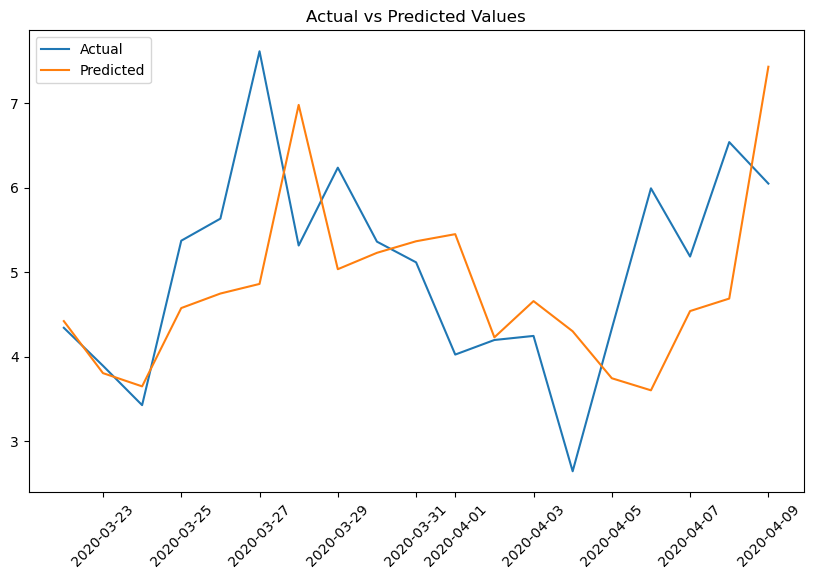

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate X-axis labels by 45 degrees
plt.legend()
plt.show()


### Forecasting Future Time Steps

In [13]:
import numpy as np

# Function to forecast multiple time steps into the future
def forecast_future(model, initial_data, steps=10):
    """
    Forecast future values using an XGBoost model.
    
    Args:
    - model: Trained XGBoost model.
    - initial_data: Most recent lagged features (as DataFrame) used for forecasting.
    - steps: Number of future time steps to predict.
    
    Returns:
    - future_values: List of predicted future values.
    """
    
    # Create an empty list to store future predictions
    future_values = []
    
    # Extract the latest known features (lag features from the most recent time step)
    input_data = initial_data[-1:].values.reshape(1, -1)  # Take the last row and reshape for prediction
    
    # Iteratively forecast the specified number of steps
    for _ in range(steps):
        # Predict the next value
        prediction = model.predict(input_data)
        
        # Append the predicted value to the list
        future_values.append(prediction[0])
        
        # Shift the lag features: remove the oldest lag and add the new prediction as the latest lag
        input_data = np.roll(input_data, -1)  # Shift all values one position to the left
        input_data[0, -1] = prediction[0]  # Replace the last position with the new prediction
    
    return future_values


### Forecasting Future Values

In [14]:
# Get the most recent data points for forecasting (lag features)
latest_data = X_test.tail(1)

# Forecast the next 10 steps
future_forecast = forecast_future(model, latest_data, steps=10)

# Display the predicted future values
print(f"Future Predictions for the next 10 steps: {future_forecast}")


Future Predictions for the next 10 steps: [7.431489, 3.0883532, 5.585705, 2.1841955, 4.7950463, 1.521332, 4.6242914, 1.4575839, 6.8882604, 2.4246995]


### Vizualizing the forecast

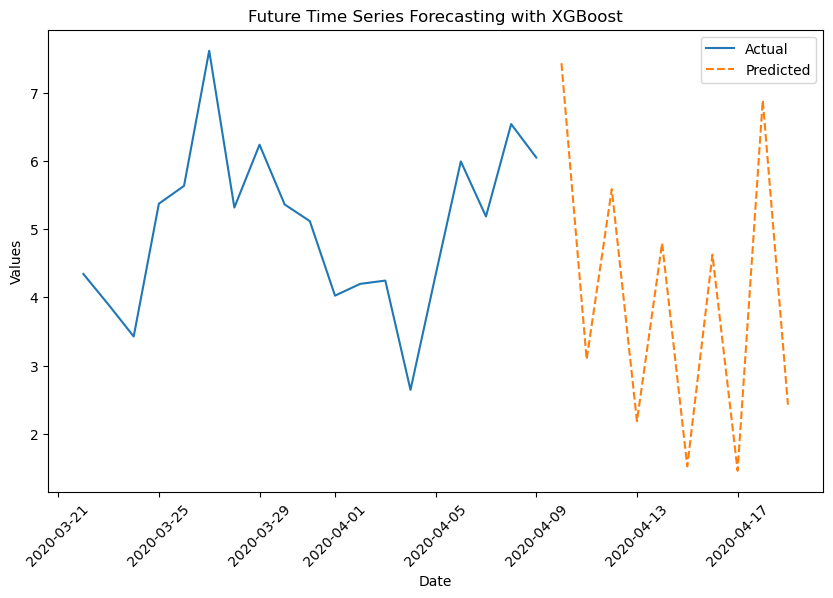

In [16]:
import matplotlib.pyplot as plt

# Generate the dates for the future predictions (extend the original date range)
future_dates = pd.date_range(start=X_test.index[-1], periods=11, freq='D')[1:]  # Skip the first date to match steps

# Convert the forecast to a DataFrame for easy plotting
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Value': future_forecast})
future_df.set_index('Date', inplace=True)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))

# Plot actual values from the test set
plt.plot(X_test.index, y_test, label='Actual')

# Plot the future predictions
plt.plot(future_df.index, future_df['Predicted_Value'], label='Predicted', linestyle='--')

# Add labels and legend
plt.title('Future Time Series Forecasting with XGBoost')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate X-axis labels by 45 degrees
plt.legend()
plt.show()
